In [101]:
import os
import json
import datetime
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

## Gerekli fonksiyonlar

In [136]:
def pad_image(image_path):
  image = Image.open(image_path).convert('RGB')
  new_img = Image.new('RGB',(350,350),color=0)
  image = T.Resize(224,max_size=320)(image)
  x = (new_img.width - image.width) // 2
  y = (new_img.height - image.height) // 2
  new_img.paste(image,(x,y))
  return new_img, new_img.size

def sort_image_list(lst):
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-4:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def display_images_labels(imgs_lst,image_label_dictionary):
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def create_images_list(dir,sort=False,fullPath=False):
  lst = os.listdir(dir)

  if sort:
    lst = sort_image_list(lst)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def merge_image_directories(dir1,dir2,sort=False,fullPath=False):
  list1 = create_images_list(dir1,sort,fullPath)
  list2 = create_images_list(dir2,sort,fullPath)
  total = list1 + list2
  return total

def get_selected_indexes(indexes:list,elements:list):
  arr = []
  for idx in indexes:
    arr.append(elements[idx])
  return arr

def get_labels(images,image_lbl_dict):
  arr = []
  for img in images:
    arr.append(image_lbl_dict[img])
  return arr

## Image list must be sorted before call this function.
## For sorting call sort_image_list function before.
def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def create_cm(actual_labels,predicted,classes):
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()

def search(arr,idx,element):
  if element ==-1:
    j=idx+1
    element = arr[idx]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

def load_image(image,transform):
  new_img, _ = pad_image(image)
  new_img = transform(new_img)[:3].unsqueeze(0)
  return new_img

def compute_embeddings(image_paths,device,transform,transformer):
  all_embeddings = {}
  with torch.no_grad():
    for _, img in enumerate(tqdm(image_paths,desc="Processing files")):
      embeddings = transformer(load_image(img,transform).to(device))
      all_embeddings[img] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

  with open("all_embeddings.json", "w") as f:
      f.write(json.dumps(all_embeddings))
  
  return all_embeddings

def calculate_metrics(labels,predictions):
  f1 = f1_score(labels,predictions)
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall, f1

def test_model(images,img_lbl_dict,embeddings,classes,model):
  images_embeddings = get_labels(images,embeddings)
  embeddings_list = np.array(list(images_embeddings)).reshape(-1,384)
  with torch.no_grad():
    predictions = model.predict(embeddings_list)
    labels = get_labels(images,img_lbl_dict)
    res = calculate_metrics(labels,predictions)
    print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}, F1 score: {res[3]}")
    create_cm(labels,predictions,classes)


In [103]:
furkan_images_dir = "./dataset/Furkan_Pan/images"
gamze_images_dir = "./dataset/Gamze_Pan/images"
furkan_excel_path = "./dataset/Furkan_Excel.xlsx"
gamze_excel_path = "./dataset/Gamze_Excel.xlsx"
total_excel_path = "./dataset/Total_Excel.xlsx"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.5])])
classes = ["Hatasız","Hatalı"]

In [104]:
labels_file = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
total_images_paths = merge_image_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
img_lbl_dict = create_img_label_dict(total_images_paths,labels_file,column_num=1)
pd.Series({
    "labels file length =" : len(labels_file),
    "images list length =" : len(total_images_paths),
    "dictionary  length =" : len(img_lbl_dict)
}).to_frame().style.hide(axis='columns')

In [105]:
images_paths = random.sample(total_images_paths,1400)         ## Get 1400 sample randomly for training.
print(f"For train: {len(images_paths)}, Total: {len(total_images_paths)}")

For train: 1400, Total: 1497


In [106]:
#print(f"Repeated Elements: {findRepeatedElements(images_paths)}")
test_images = getNotFoundElements(total_images_paths,images_paths)
print(f"Test images: {len(test_images)}")

Test images: 97


In [107]:
display_images_labels(images_paths,img_lbl_dict)

Image  Label
0       ./dataset/Furkan_Pan/images\80.jpg      0
1     ./dataset/Furkan_Pan/images\2172.jpg      1
2      ./dataset/Gamze_Pan/images\3103.bmp      0
3     ./dataset/Furkan_Pan/images\2012.jpg      0
4     ./dataset/Furkan_Pan/images\2091.jpg      1
...                                    ...    ...
1395   ./dataset/Gamze_Pan/images\2873.jpg      0
1396    ./dataset/Furkan_Pan/images\31.jpg      0
1397  ./dataset/Furkan_Pan/images\2068.jpg      1
1398  ./dataset/Furkan_Pan/images\2065.jpg      0
1399   ./dataset/Furkan_Pan/images\287.jpg      0

[1400 rows x 2 columns]

## Hangi resize işlemi kullanayım diye bu iki scripti çalıştırıyorum.


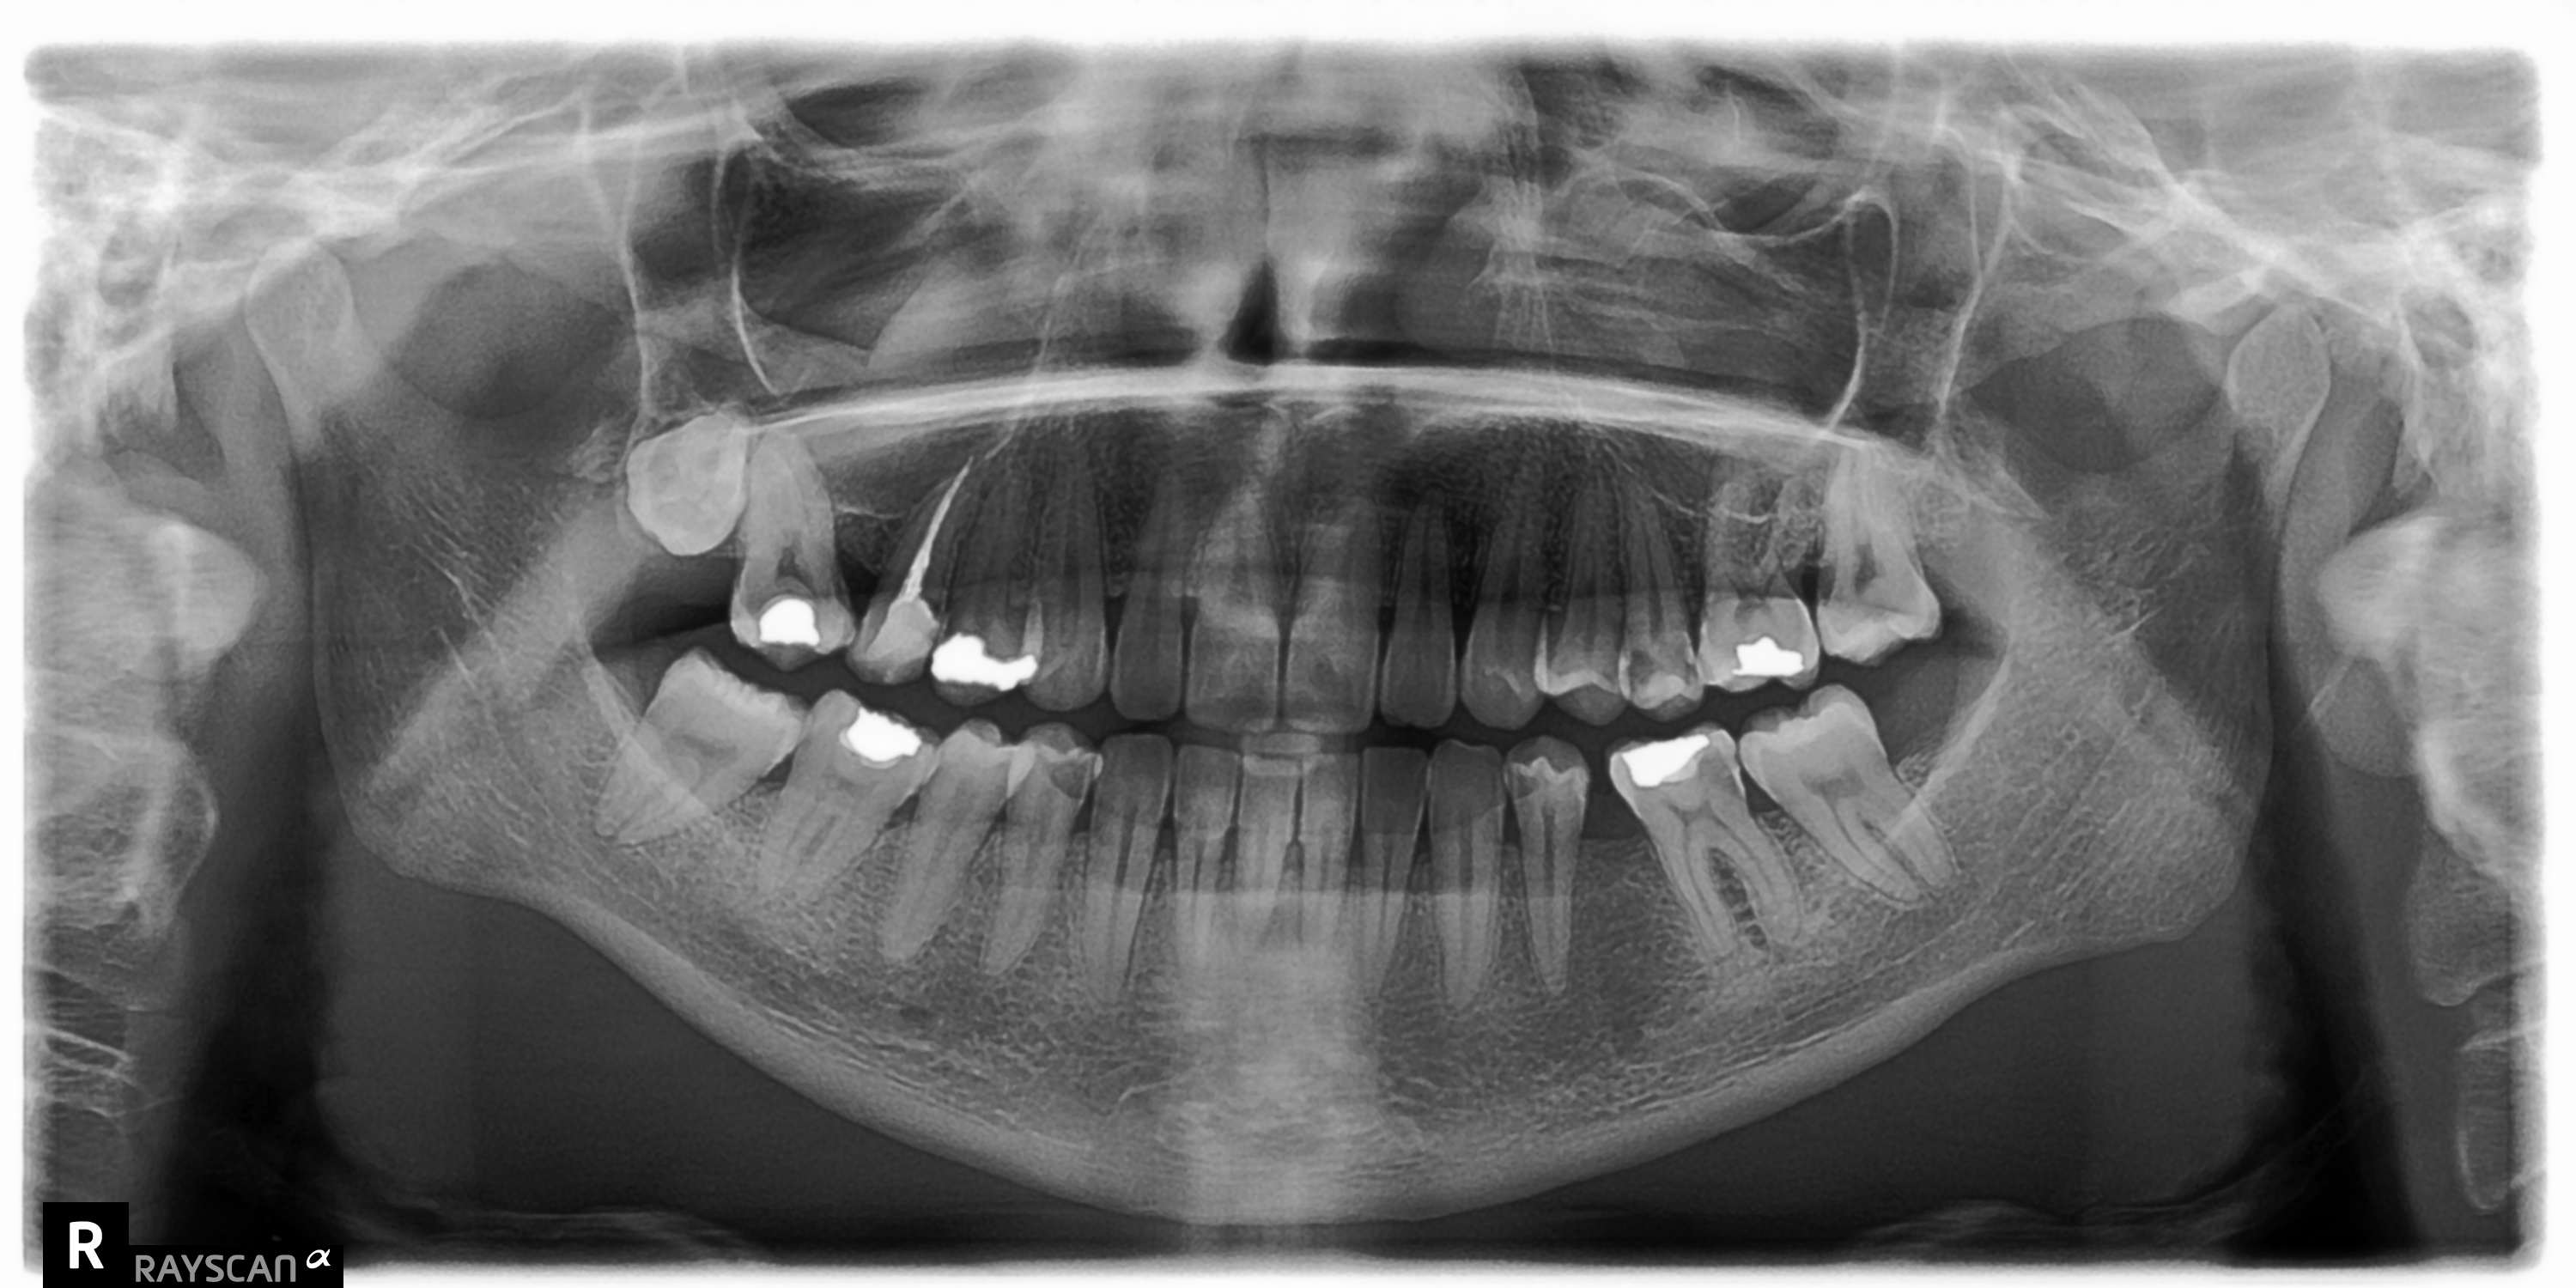

In [108]:
path = random.choice(total_images_paths)
sample = Image.open(path).convert('RGB')
sample

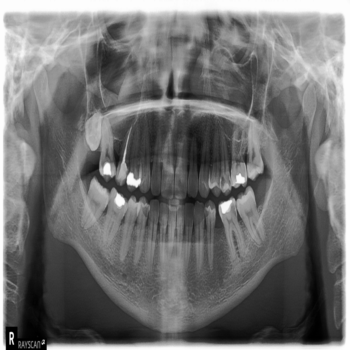

In [109]:
transformed = T.Resize((350,350))(sample)
transformed

(350, 350)


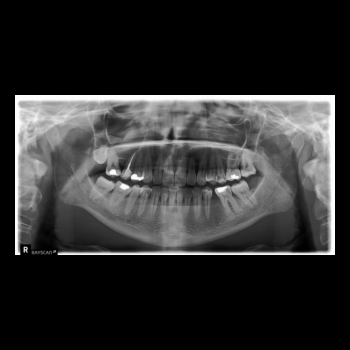

In [110]:
img, info = pad_image(path)
print(info)
img

## Training

In [111]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\esamh/.cache\torch\hub\facebookresearch_dinov2_main


In [112]:
clf = svm.SVC(probability=True,gamma='scale')               ## Initialize classifier
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [115]:
total_embeddings = compute_embeddings(total_images_paths,device,transform,dinov2_vits14)

Processing files: 100%|██████████| 1497/1497 [05:00<00:00,  4.99it/s]


Fold 1/5
Accuracy: 0.6214285714285714, Precision: 0.603448275862069, Recall: 0.7394366197183099, F1 Score: 0.6645569620253164
Fold 2/5
Accuracy: 0.5928571428571429, Precision: 0.6226415094339622, Recall: 0.6470588235294118, F1 Score: 0.6346153846153846
Fold 3/5
Accuracy: 0.6571428571428571, Precision: 0.6647058823529411, Recall: 0.743421052631579, F1 Score: 0.701863354037267
Fold 4/5
Accuracy: 0.6107142857142858, Precision: 0.5934065934065934, Recall: 0.7552447552447552, F1 Score: 0.6646153846153846
Fold 5/5
Accuracy: 0.6392857142857142, Precision: 0.6944444444444444, Recall: 0.6369426751592356, F1 Score: 0.6644518272425248


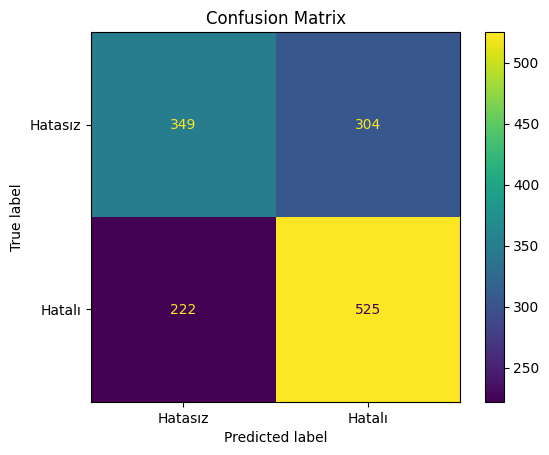

In [119]:
## Train loop
metrics = []
predicted = []
actual_lbls = []
model = None
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  train_emb = get_labels(x_train,total_embeddings)
  test_emb = get_labels(x_test,total_embeddings)

  train_embb = np.array(list(train_emb)).reshape(-1,384)
  test_embb = np.array(list(test_emb)).reshape(-1,384)
  ## Get corresponding labels.
  y_train = get_labels(x_train,img_lbl_dict)
  y_test = get_labels(x_test,img_lbl_dict)

  model = clf.fit(train_embb,y_train)
  predictions = model.predict(test_embb)
  
  predicted.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}, F1 Score: {res[3]}")
  metrics.append(res)

create_cm(actual_lbls,predicted,classes)          ## Draw confusion matrix

In [120]:
## Save the model
project_dir = Path("/content/drive/MyDrive/Models/")
project_dir.mkdir(parents=True, exist_ok=True)
with open('./dinv2_vit14_model_with_svm.pth', 'wb') as model_file:
    pickle.dump(model, model_file)

## Training sonucunda modelin performansı gösterme

In [142]:
avg_acc, avg_precision, avg_recall, avg_f1= 0, 0, 0, 0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]
    avg_f1 += metrics[i][3]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K
avg_f1 = 100*avg_f1/K

pd.Series({
    "Average Accuracy" : [avg_acc],
    "Average Precision": [avg_precision],
    "Average Recall" : [avg_recall],
    "Average F1 Score" : [avg_f1]
}).to_frame().style.hide(axis='columns')


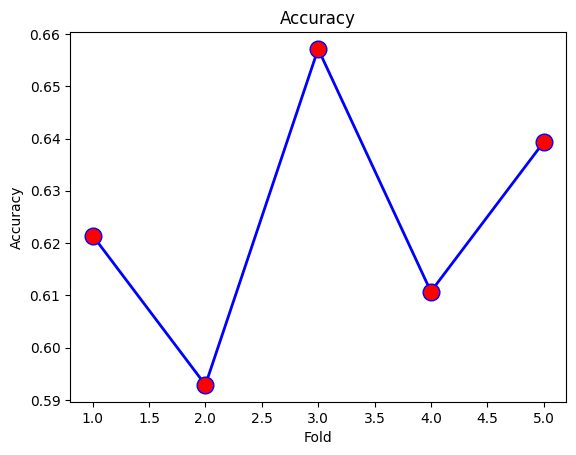

In [130]:
plt.plot(range(1,K+1),acc,color="blue",linewidth = 2,marker='o', markerfacecolor='red', markersize=12)
plt.title("Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

## Sadece 97 resim üzerinde test yapar.
Bu resimler training aşamasına dahil edilmedi.

Accuracy: 0.6597938144329897, Precision: 0.7166666666666667, Recall: 0.7288135593220338, F1 score: 0.7226890756302521


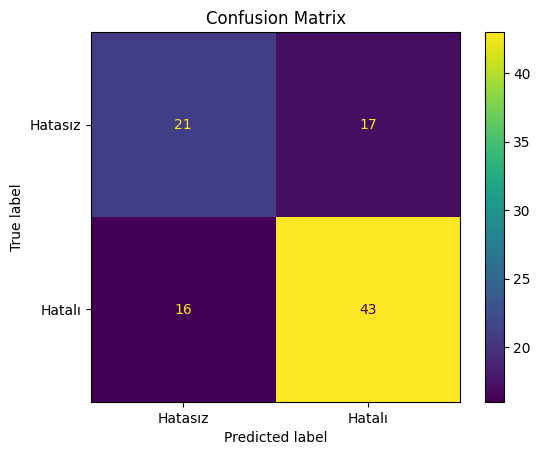

In [137]:
test_model(test_images,img_lbl_dict,total_embeddings,classes,model)


## Bütün resimler için test

Accuracy: 0.6666666666666666, Precision: 0.6851628468033776, Recall: 0.7047146401985112, F1 score: 0.6948012232415902


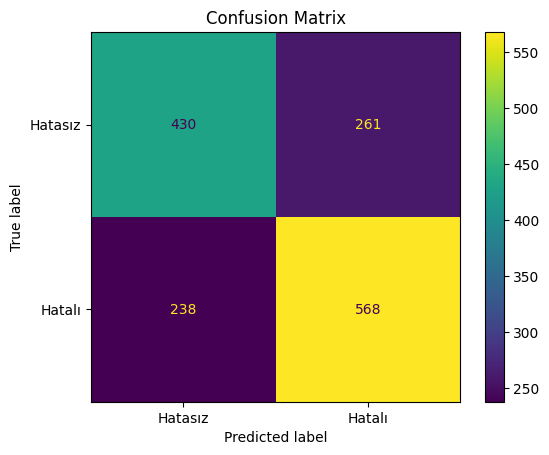

In [138]:
test_model(total_images_paths,img_lbl_dict,total_embeddings,classes,model)